## Import Library

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Model with multiple inputs and outputs
The functional API makes it easy to manipulate multiple inputs and outputs. This cannot be handled with the <b>Sequential</b> API.

For example, if you're building a system for ranking customer issue tickets by priority and routing them to the correct department, then the model will have three inputs:

    - the title of the ticket (text input),
    - the text body of the ticket (text input), and
    - any tags added by the user (categorical input)
This model will have two outputs:

    - the priority score between 0 and 1 (scalar sigmoid output), and
    - the department that should handle the ticket (softmax output over the set of departments).

In [2]:
# number of unique issue tags
num_tags=12

# size of vocabulary obtained when processing text data
num_words=10000

# number of department for predictions
num_departments=4

## Define the models inputs

In [5]:
#variable length of sequence of ints
title_input=keras.Input(shape=(None,),name='title')

# variable length
body_input=keras.Input(shape=(None,),name='body')

#Binary vector of size num tags
tags_input=keras.Input(shape=(num_tags,),name='tags')

## Define the Features

In [6]:
# embed each word in the title into a 64 dimensional vector
title_features=layers.Embedding(num_words,64)(title_input)

# embed each word in the text into a 64 dimensional vector
body_features=layers.Embedding(num_words,64)(body_input)

In [7]:
#Reduce the sequence of embeded words in the title into a single 128 D vector
title_features=layers.LSTM(128)(title_features)

#Reduce the sequence of embeded words in the title into a single 32 D vector
body_features=layers.LSTM(32)(body_features)

## Merge Layers: Concatenation
Merge all available features into a single large vector via concatenation

In [8]:
x=layers.concatenate([title_features,body_features,tags_input])

In [12]:
x.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'concatenate/concat:0' shape=(None, 172) dtype=float32>>

## Define Model Prediction Layer

In [13]:
# stick a logistic regression for priority prediction on top of the features
priority_pred=layers.Dense(1,name='priority')(x)

# stick a department classifier on top of the features
department_pred=layers.Dense(num_departments,name='department')(x)

## Compile the model 
Instantiate an end-to-end model prediction both priority and department

In [48]:
model=keras.Model(
    inputs=[title_input,body_input,tags_input],
    outputs=[priority_pred,department_pred],
    name='MultiModel'
)

## Analysis the model

In [17]:
model.summary()

Model: "Multi Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      body[0][0]                       
________________________________________________________________________________________

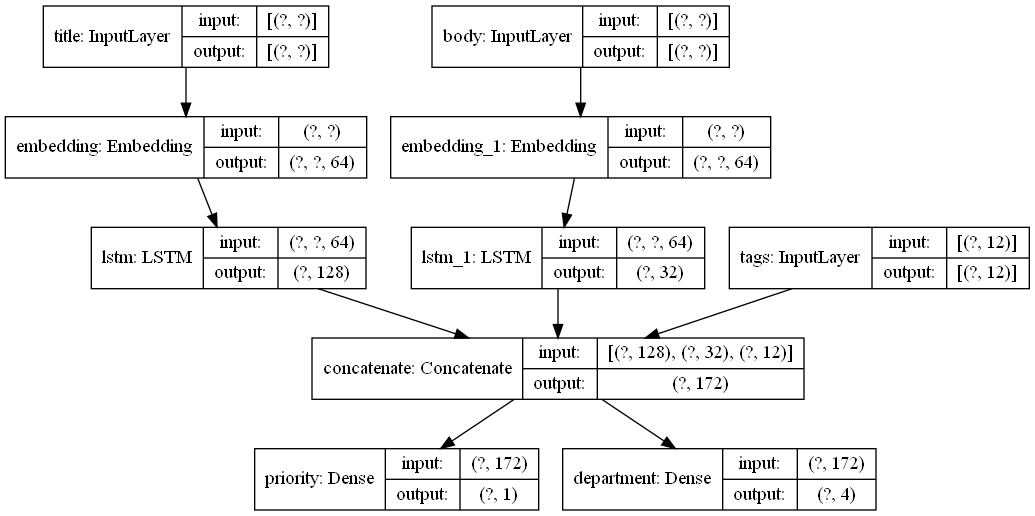

In [18]:
keras.utils.plot_model(model,'multi_input_and_output_model.png',show_shapes=True)

## Model Compilation
When compiling this model, you can assign different losses to each output. You can even assign different weights to each loss -- to modulate their contribution to the total training loss.

In [42]:
"""

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[
        keras.losses.BinaryCrossentropy(from_logits=True),
        keras.losses.CategoricalCrossentropy(from_logits=True)
    ],
    loss_weights=[1.0,0.2]

)
"""

'\n\nmodel.compile(\n    optimizer=keras.optimizers.RMSprop(1e-3),\n    loss=[\n        keras.losses.BinaryCrossentropy(from_logits=True),\n        keras.losses.CategoricalCrossentropy(from_logits=True)\n    ],\n    loss_weights=[1.0,0.2]\n\n)\n'

In [49]:
# Since the model have differentt name, specify the loss like:

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "priority": keras.losses.BinaryCrossentropy(from_logits=True),
        "department": keras.losses.CategoricalCrossentropy(from_logits=True),
    },
    loss_weights=[1.0, 0.2],
)

## Prepare input and output for trained the network

In [21]:
## Dummy input data
title_data=np.random.randint(num_words,size=(1280,10))
body_data=np.random.randint(num_words,size=(1280,100))
tags_data=np.random.randint(2,size=(1280,num_tags)).astype('float32')

In [28]:
print(title_data.shape)
title_data[0]

(1280, 10)


array([5791, 1486, 9700, 1269, 9254, 3751, 8667, 7650, 4904, 2488])

In [29]:
print(body_data.shape)
body_data[0]

(1280, 100)


array([5134, 8400, 9191, 1725, 7973,  611, 3280, 5086, 8238, 4851, 8401,
        991,  383, 2770, 3919, 8442, 8501,  518, 9927, 2488, 3412, 1412,
        959, 7061, 2448, 6664, 9874,  845, 2751, 4739, 5371, 8725, 9011,
       9959, 5734,  273,  314, 2719, 5837,  309, 4206,  712,  443, 7541,
       1560, 6814, 6793, 5563, 8535, 4111, 8097, 5519, 6027,  481, 8928,
       2934,  659, 2051, 7118, 4395, 4505, 3009, 7035, 9911, 6061, 8699,
       9011, 1855, 2968, 1404, 4702, 3427, 1565,  953, 5412, 6954, 9404,
       4117, 9439, 8094, 3810, 6957, 9843, 6796, 9758, 3091, 1827, 2029,
       8296, 4579, 4400, 2768, 2709, 9452, 3196, 2731, 7619, 8684, 9746,
       9776])

In [30]:
print(tags_data.shape)
tags_data[0]

(1280, 12)


array([0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1.], dtype=float32)

In [32]:
## Dummpy target data
priority_targets=np.random.random(size=(1280,1))
dept_targets=np.random.randint(2,size=(1280,num_departments))

In [34]:
print(priority_targets.shape)
priority_targets[0]

(1280, 1)


array([0.72158879])

In [35]:
print(dept_targets.shape)
dept_targets[0]


(1280, 4)


array([1, 0, 0, 1])

## Trained Model

In [51]:
model.fit(
    {"title": title_data, "body": body_data, "tags": tags_data},
    {"priority": priority_targets, "department": dept_targets},
    epochs=10,
    batch_size=32,
)

Epoch 1/10
40/40 [==============================] - 1s 24ms/step - loss: 1.2551 - priority_loss: 0.7005 - department_loss: 2.7733
Epoch 2/10
40/40 [==============================] - 1s 30ms/step - loss: 1.2544 - priority_loss: 0.7001 - department_loss: 2.7713
Epoch 3/10
40/40 [==============================] - 2s 45ms/step - loss: 1.2531 - priority_loss: 0.6994 - department_loss: 2.7684
Epoch 4/10
40/40 [==============================] - 1s 37ms/step - loss: 1.2474 - priority_loss: 0.6937 - department_loss: 2.7684
Epoch 5/10
40/40 [==============================] - 1s 24ms/step - loss: 1.2454 - priority_loss: 0.6915 - department_loss: 2.7694
Epoch 6/10
40/40 [==============================] - 1s 28ms/step - loss: 1.2472 - priority_loss: 0.6943 - department_loss: 2.7645
Epoch 7/10
40/40 [==============================] - 2s 45ms/step - loss: 1.2437 - priority_loss: 0.6936 - department_loss: 2.7508
Epoch 8/10
40/40 [==============================] - 2s 38ms/step - loss: 1.2427 - priority

## Saved Moded

In [56]:
import time
t=time.time()
model_path='Saved Model/MultiGraphModel_{}.h5'.format(int(t))
print(model_path)

Saved Model/MultiGraphModel_1620543935.h5


In [57]:
model.save(model_path)

## Load Model

In [59]:
reload_model=keras.models.load_model(model_path)
reload_model.summary()

Model: "MultiModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      body[0][0]                       
_________________________________________________________________________________________